Load stacked edge data, and write basic viz functions to plot edges etc.

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [2]:
import re
import os

In [3]:
from multiprocessing import Pool
from itertools import repeat

In [4]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
# plt.rc("text", usetex=True)

In [5]:
def load_edge_data(eventID):
    edge_data = np.load("./edge_data/CR{}_stacked_edge.npy".format(eventID))
    simID_data = np.load("./edge_data/CR{}_SimID4edge.npy".format(eventID))
    
    all_sims = []
    
    for s in simID_data:
        mm = re.search("run\d\d\d_AWSoM2T", s)
        all_sims.append(int(mm.group().split("run")[1].split("_")[0]))
    
    return edge_data, np.array(all_sims)

In [6]:
ed_2161, sd_2161 = load_edge_data(2161)
ed_2192, sd_2192 = load_edge_data(2192)
ed_2154, sd_2154 = load_edge_data(2154)

In [7]:
nTimes = ed_2161.shape[0]
nTimes

90

In [8]:
nTheta_2161 = ed_2161.shape[1]
nTheta_2192 = ed_2192.shape[1]
nTheta_2154 = ed_2154.shape[1]
nTheta_2161, nTheta_2192, nTheta_2154

(200, 185, 400)

In [9]:
nSims_2161 = ed_2161.shape[2]
nSims_2192 = ed_2192.shape[2]
nSims_2154 = ed_2154.shape[2]
nSims_2161, nSims_2192, nSims_2154

(278, 231, 141)

Workflow to filter data before it reaches boundary i.e. look for values going along indices above 120 , pick the minimum row index as cutoff for entire range of angles, and set that as the time up to which we have training and or testing data.

In [10]:
R_inner = 4.05
R_outer = 23.6

In [11]:
height_flattened=128
np.arange(0, height_flattened, step=21)

array([  0,  21,  42,  63,  84, 105, 126])

In [12]:
hts_pixel = np.linspace(0, height_flattened, height_flattened + 1)
hts_pixel

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128.])

In [13]:
# is this correct?
radii = ((hts_pixel)/height_flattened)*(R_outer - R_inner) + R_inner
radii

array([ 4.05      ,  4.20273437,  4.35546875,  4.50820312,  4.6609375 ,
        4.81367187,  4.96640625,  5.11914062,  5.271875  ,  5.42460938,
        5.57734375,  5.73007813,  5.8828125 ,  6.03554687,  6.18828125,
        6.34101562,  6.49375   ,  6.64648438,  6.79921875,  6.95195312,
        7.1046875 ,  7.25742188,  7.41015625,  7.56289062,  7.715625  ,
        7.86835937,  8.02109375,  8.17382812,  8.3265625 ,  8.47929687,
        8.63203125,  8.78476563,  8.9375    ,  9.09023437,  9.24296875,
        9.39570313,  9.5484375 ,  9.70117188,  9.85390625, 10.00664062,
       10.159375  , 10.31210938, 10.46484375, 10.61757812, 10.7703125 ,
       10.92304688, 11.07578125, 11.22851562, 11.38125   , 11.53398437,
       11.68671875, 11.83945313, 11.9921875 , 12.14492188, 12.29765625,
       12.45039063, 12.603125  , 12.75585938, 12.90859375, 13.06132812,
       13.2140625 , 13.36679687, 13.51953125, 13.67226563, 13.825     ,
       13.97773438, 14.13046875, 14.28320312, 14.4359375 , 14.58

In [14]:
ed_2161_scaled = (ed_2161/height_flattened)*(R_outer - R_inner) + R_inner
ed_2192_scaled = (ed_2192/height_flattened)*(R_outer - R_inner) + R_inner
ed_2154_scaled = (ed_2192/height_flattened)*(R_outer - R_inner) + R_inner

Adapted function from `plot_heat_data` in previous notebooks.

In plotting we need to convert axes indices to actual theta and R values (also control the ticks) - follow basic outline of `Kmeans_CR2154_SignedDist` from Hongfan.

**Calculation for angles**

In [15]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[359] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

theta_s_2192, theta_e_2192 = np.linspace(0, 360, 512)[90] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[274] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2192, theta_e_2192))

theta_s_2154, theta_e_2154 = np.linspace(0, 360, 512)[50] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[449] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2154, theta_e_2154))

Range of angles for CR2161: -31.279843444227026 108.91585127201563
Range of angles for CR2161: -80.59491193737767 49.03326810176122
Range of angles for CR2161: -108.77495107632095 172.32093933463796


~~Can we also make a Cartesian plot? easier to see all edges progressing outward (with overlaid radius of occulting disk) and get a better sense of the shape.~~

Save for all sims and events.

In [16]:
actualTimes = np.arange(2, 182, 2)

In [17]:
edge_save_dir = "./edge_img"

In [18]:
ed_2192.max()

136.27816512833152

**Threshold the edges**

Set a cutoff time for plotting the edges, because if edge reaches the boundary very quickly, the algorithm breaks down after the cutoff and can result in incorrect edges (0 values, non-monotonic behaviour etc). so we need to filter the data correctly before using it for plotting / training purposes.

In [19]:
# cutoff_value = 120
# t_cutoff_idx = []
# for j in range(ed_2161.shape[2]):
#     for i in range(ed_2161.shape[0]):
#         boundary_idx = np.where(ed_2161[i, :, j])

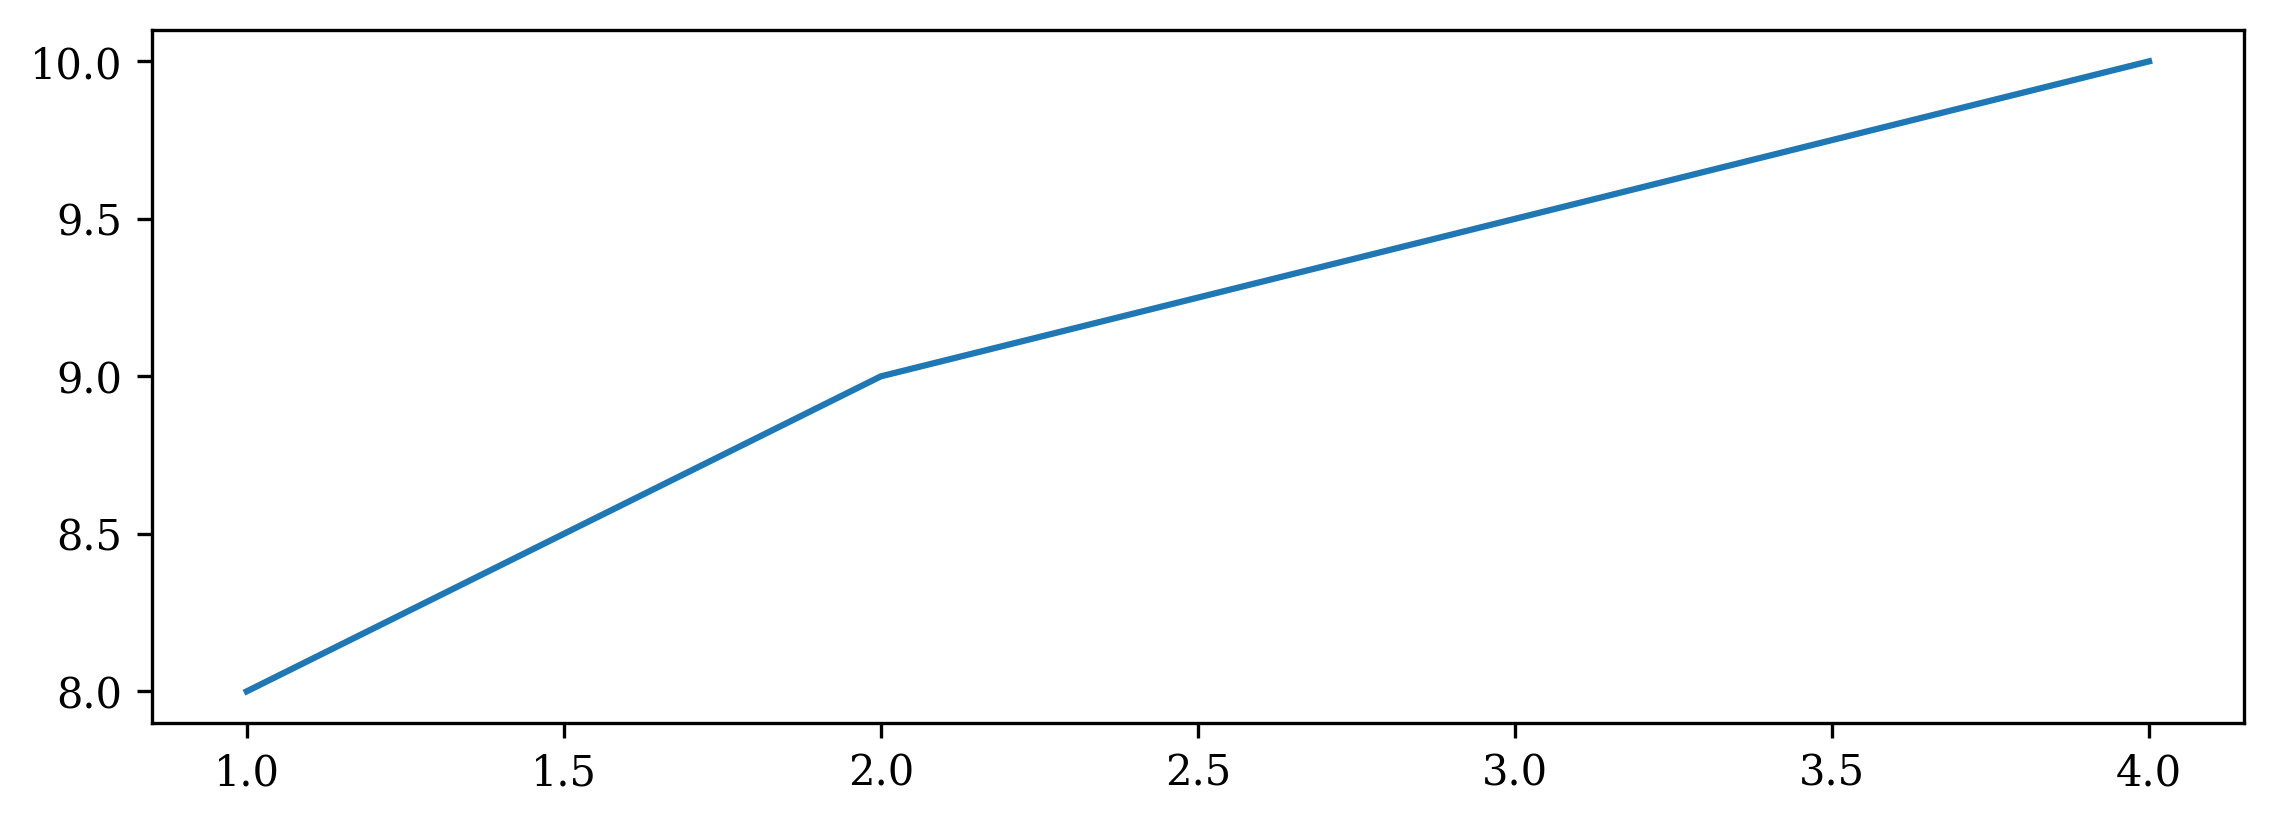

In [20]:
plt.plot([1, 2, 4], [8, 9, 10])

In [21]:
def plot_edge_data(Z, titleSim, eventID=2161, plotAll=False, ax=None, theta=np.linspace(-32, 107, 200)):
    """Visualize edges data in space and time both in polar and original Cartesian coordinates."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    if plotAll:
        sample_columns = [i for i in range(Z.shape[1])]
    else:
        sample_columns = [0, 2, 4, 8, 12, 20, 40, 50, 60, 70, 74, 80, 84, 88, 89]
        
    sample_times = actualTimes[sample_columns]
    color = iter(plt.cm.viridis(np.linspace(0, 1, len(sample_columns))))
    while sample_columns[-1] > Z.shape[1]:
        sample_columns.pop()
    for i, j in enumerate(sample_columns):
        ax.plot(theta, Z[:, j], color=next(color), label=fr"$u(t_{{{sample_times[i]}}})$")

    ax.set_xlabel(r"$theta (deg)$")
    ax.set_ylabel(r"$r_{edge}(t)$")
    
    ax.set_xlim(theta[0], theta[-1])
    ax.set_yticks(np.arange(0, height_flattened, step=21), labels=['4R', '7R', '10R', '13R', '16R', '19R', '24R'])
    ax.legend(loc=(1.05, .05))
    ax.set_title("Edge data Sim {:03d}".format(titleSim))

In [22]:
    # commenting out save functionality for now!!
    #     plt.savefig(os.path.join(edge_save_dir, "CR{}".format(eventID), "run_{:03d}.png".format(titleSim)),
    #                bbox_inches="tight", pad_inches=0)

    #     print("Saved image for Event {} Sim {:03d}".format(eventID, titleSim))

    #     plt.close()

In [23]:
def save_event_edge_data(eventID, plotAll=False, ax=None, theta_start=160, theta_end=360):
    # call data simwise, get sim labels
    edge_data, sim_data = load_edge_data(eventID)
    edge_data = (edge_data/height_flattened)*(R_outer - R_inner) + R_inner
    # make call to plotting function (also saves image) - MultiProcessing?
    nSims = edge_data.shape[2]
    
    theta_range = np.linspace(0, 360, 512)[theta_start:theta_end] + 1.2 * 180 - 360
    for i in range(nSims):
        plot_edge_data(edge_data[:, :, i].T, sim_data[i], eventID=eventID, 
                       plotAll=False, theta=theta_range)        

In [24]:
ed_2161.shape

(90, 200, 278)

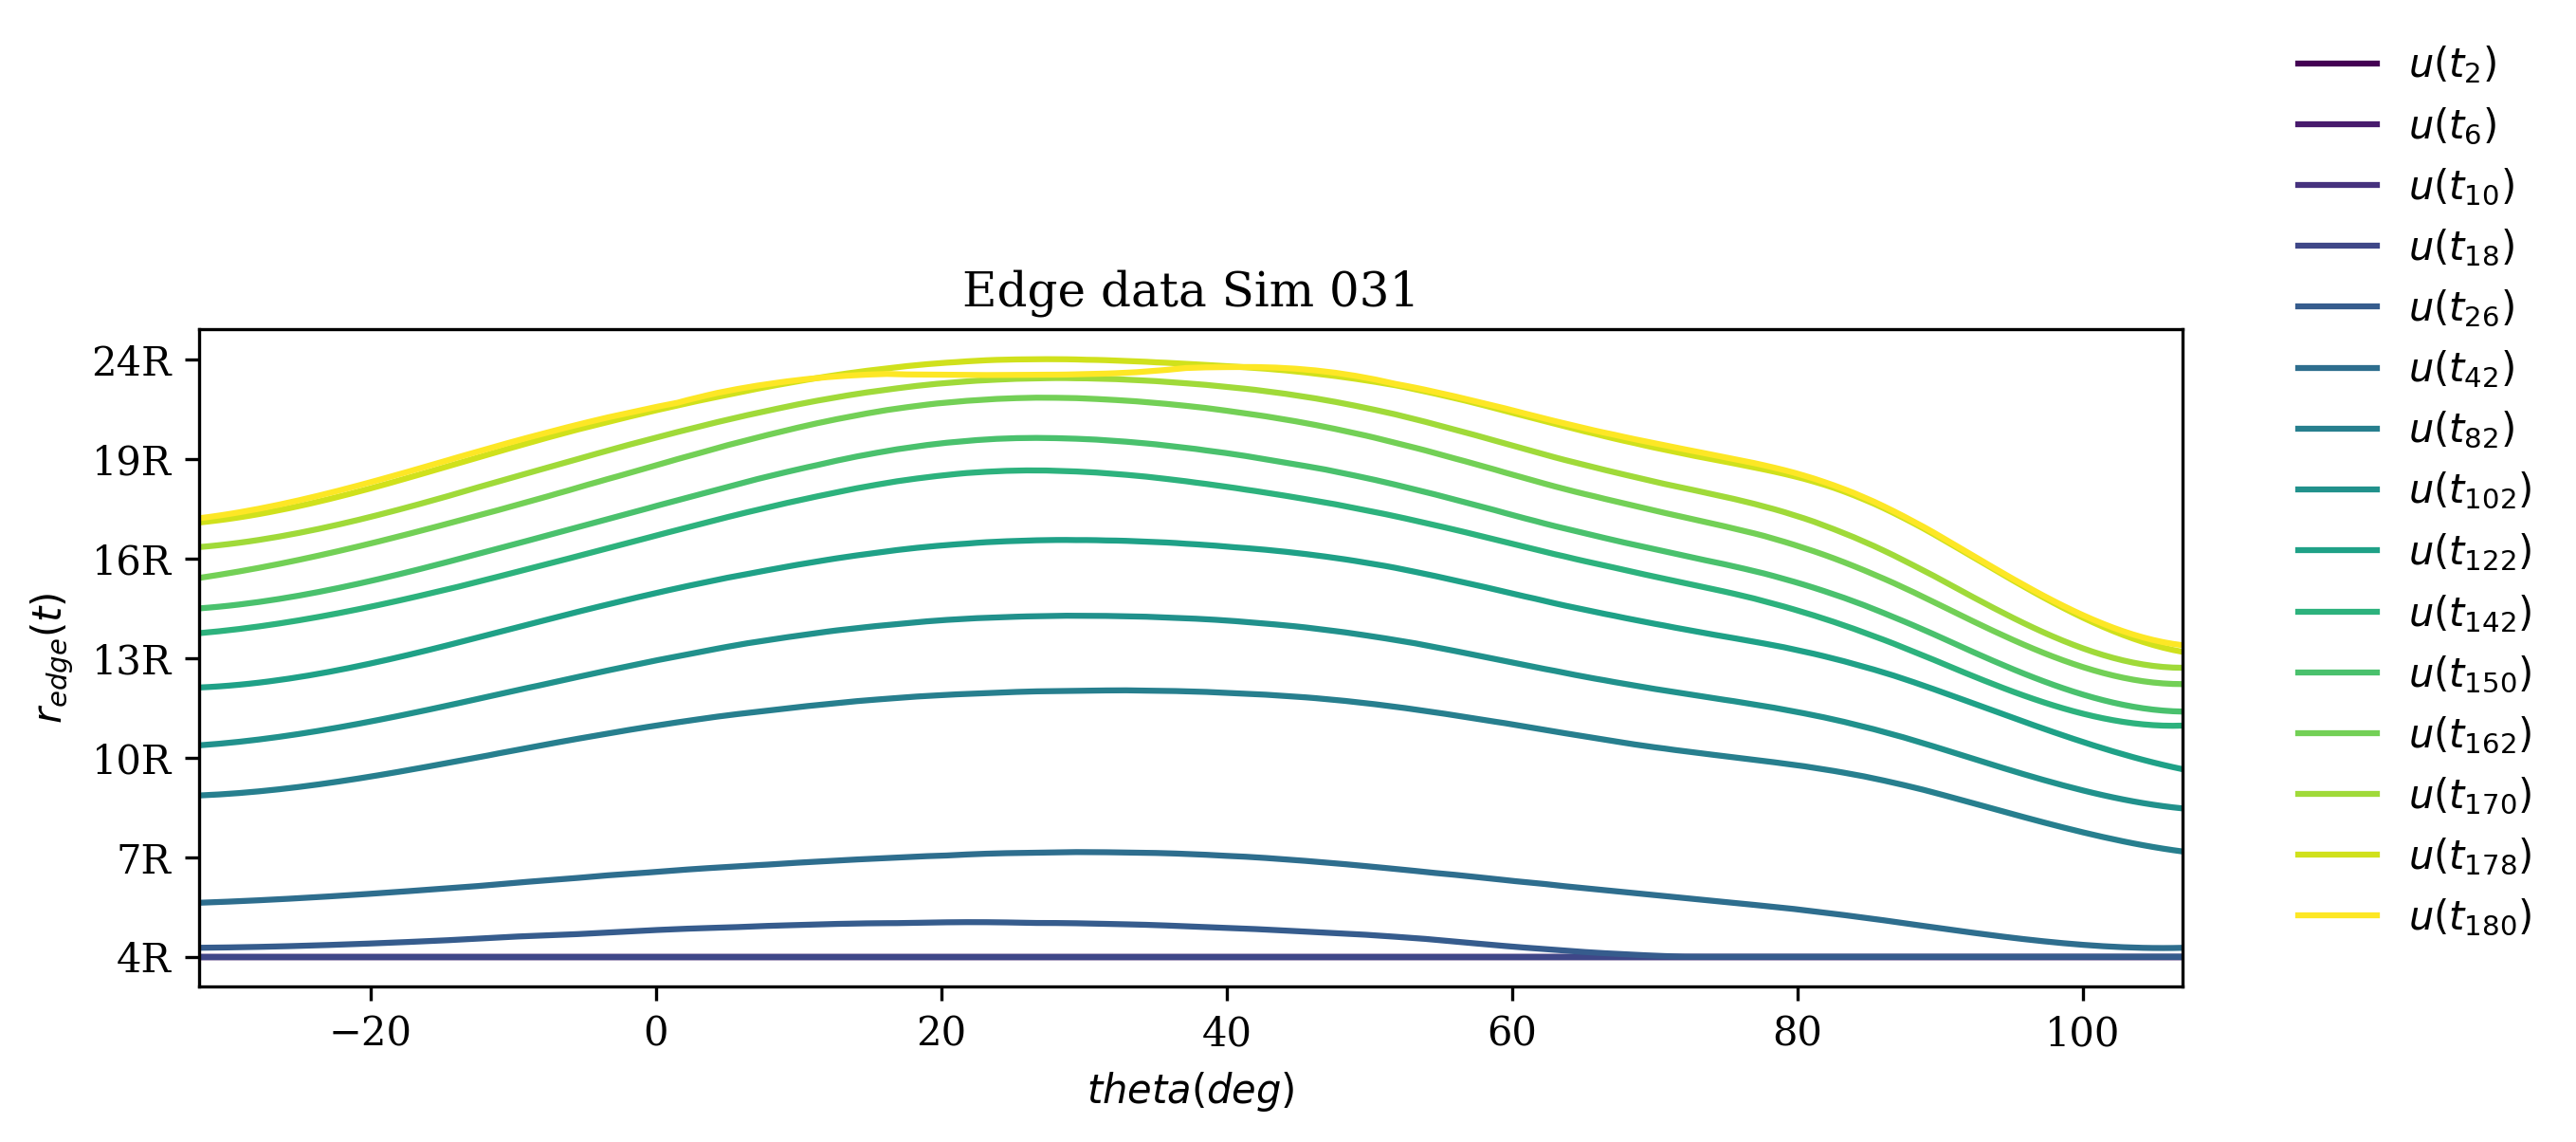

In [25]:
plot_edge_data(ed_2161[:, :, 0].T, 31, eventID=2161, plotAll=False, ax=None, theta=np.linspace(-32, 107, 200))

Are our ylims getting set correctly in the figure?

A problem with the approach is that blindly plotting edges means that we will plot lines even where the algorithm is expected to stop working reliably i.e. where the edge has reached the boundary or is too slow and the lack of monotonicity means a lot of overlap with the edges at previous timesteps.

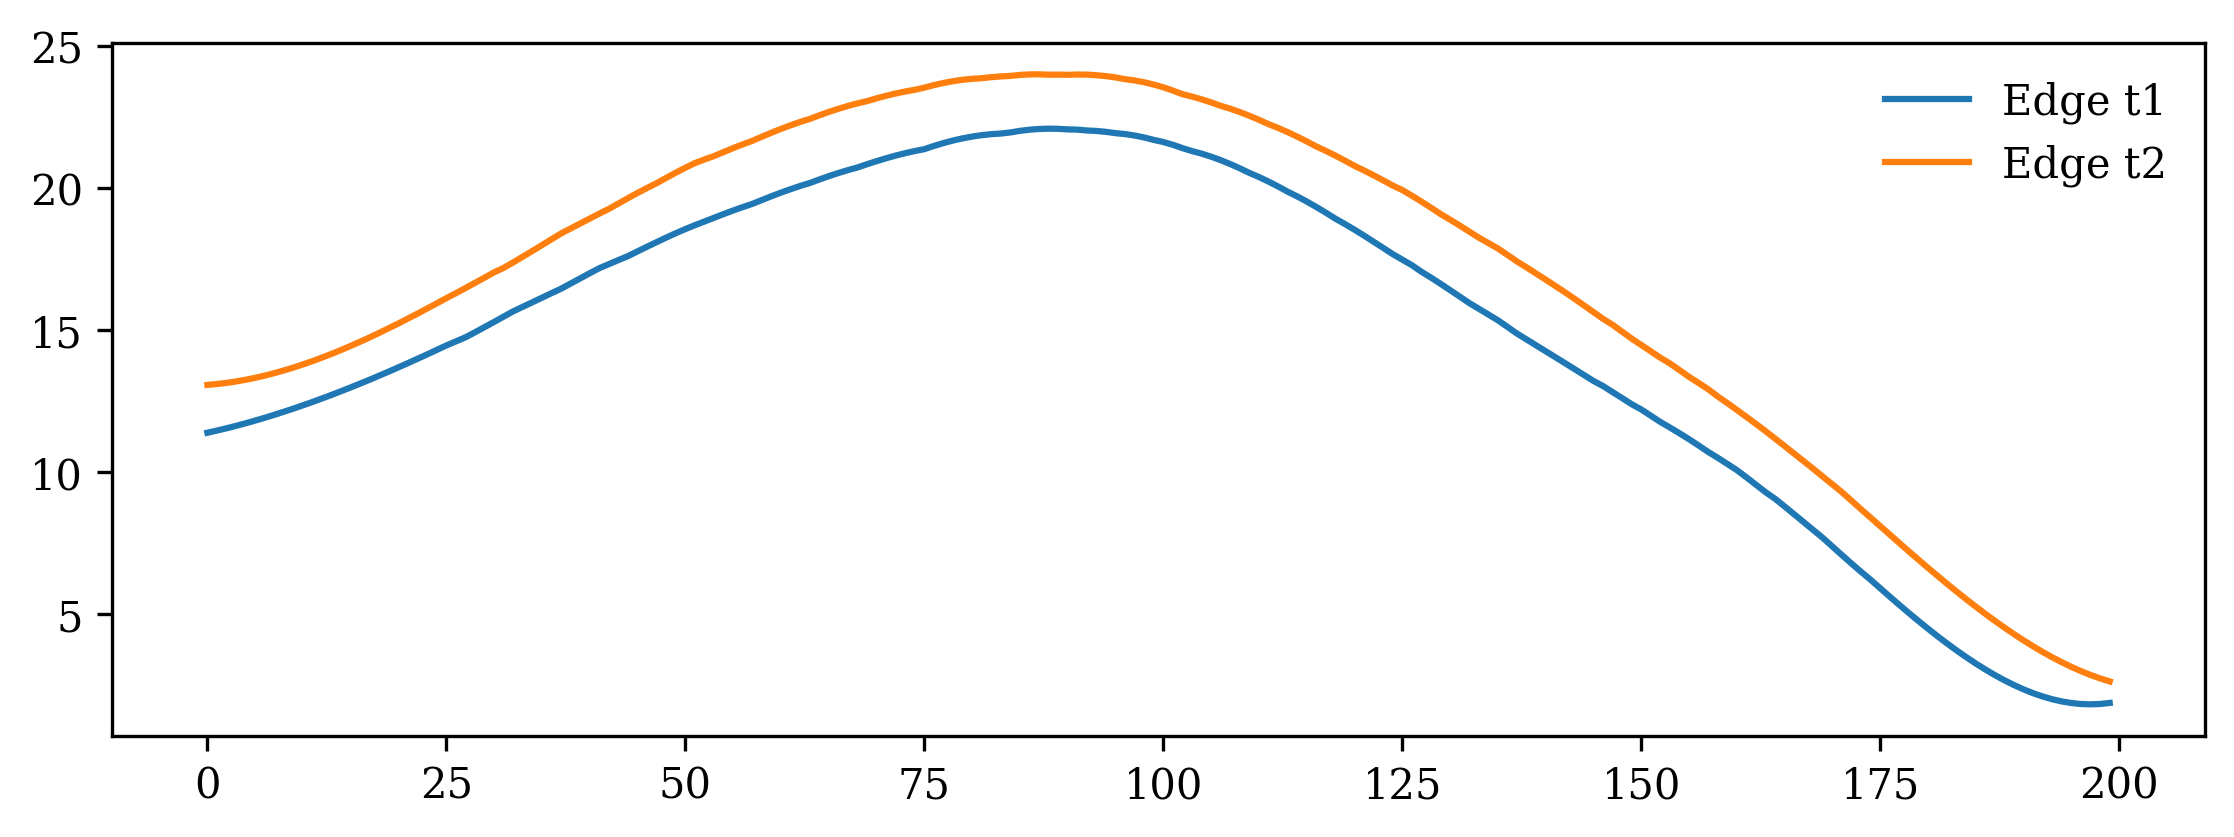

In [26]:
edge1 = ed_2161[20, :, 0]
edge2 = ed_2161[21, :, 0]

plt.plot(edge1, label="Edge t1")
plt.plot(edge2, label="Edge t2")
plt.legend()

For one sim, e.g. sim 31, find the min time at which min edge value is greater than zero. That has to be our starting point, else part of it is unobserved and we can't really use that for training.

In [27]:
ed31 = ed_2161[:, :, 0]

In [28]:
min_edge_by_time = np.min(ed31, axis=1)
min_edge_by_time

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.83155224,  2.63720905,  2.98277001,  4.64030469,  5.83225454,
        7.42256309,  7.70492109,  8.78119026, 10.73461266, 11.70396329,
       11.93201286, 13.34897281, 14.54620539, 16.31378873, 16.43065793,
       17.52078887, 18.17804212, 19.30108996, 20.47482221, 22.19464286,
       22.19494326, 23.26388533, 23.72814631, 24.98300717, 26.23653996,
       27.03983861, 28.16599157, 29.22054634, 29.77429637, 30.85050166,
       31.28291452, 32.19651479, 33.74816206, 34.32824876, 35.37695059,
       35.43583419, 36.82903769, 37.26436912, 38.09914593, 38.54793819,
       39.54311291, 40.36395458, 41.53170741, 42.67450854, 43.96433529,
       44.56513971, 44.78210067, 45.73818644, 46.79701946, 47.58

In [29]:
tMinIdx = np.where(min_edge_by_time > 0)[0][0]
tMinIdx

20

In [30]:
tMin = np.linspace(2, 180, 90)[tMinIdx]
tMin

42.0

Now set the values of selected points $(r/t)$ using `tMin` as a reference.

In [31]:
theta_samples = np.linspace(-32, 107, 200)[0:-1:2]
theta_all = np.linspace(-32, 107, 200)

In [32]:
r_by_t_ref = ed31[tMinIdx, 0:-1:2]/tMin

In [33]:
r_by_t_ref

array([0.27102922, 0.27476188, 0.27894907, 0.28356605, 0.28858809,
       0.29399044, 0.29974838, 0.30583717, 0.31223206, 0.31890832,
       0.32584121, 0.333006  , 0.34037795, 0.34751097, 0.35515554,
       0.36387655, 0.37273777, 0.38030091, 0.38790718, 0.39598319,
       0.40461791, 0.41224091, 0.41894116, 0.42683165, 0.43447406,
       0.44156638, 0.44794414, 0.45413044, 0.4599608 , 0.46590496,
       0.47209504, 0.47763796, 0.48304659, 0.48849621, 0.49313688,
       0.49843927, 0.5030945 , 0.50693   , 0.51117913, 0.51571248,
       0.5190378 , 0.5210688 , 0.52249094, 0.52478835, 0.52564044,
       0.52504722, 0.52414497, 0.52297685, 0.52112705, 0.51829087,
       0.51446023, 0.50937356, 0.50475231, 0.49928489, 0.49245844,
       0.48516603, 0.47727555, 0.46895146, 0.4601048 , 0.45030896,
       0.44104542, 0.43101607, 0.42060921, 0.41134945, 0.40092964,
       0.39048342, 0.37967047, 0.37005854, 0.35966408, 0.34916177,
       0.33922626, 0.32942287, 0.31940108, 0.31013214, 0.30001

In [34]:
t2 = tMin + 2
t2

44.0

In [35]:
r2_exact = r_by_t_ref * t2

In [36]:
r2_all = ed31[tMinIdx + 1, :]

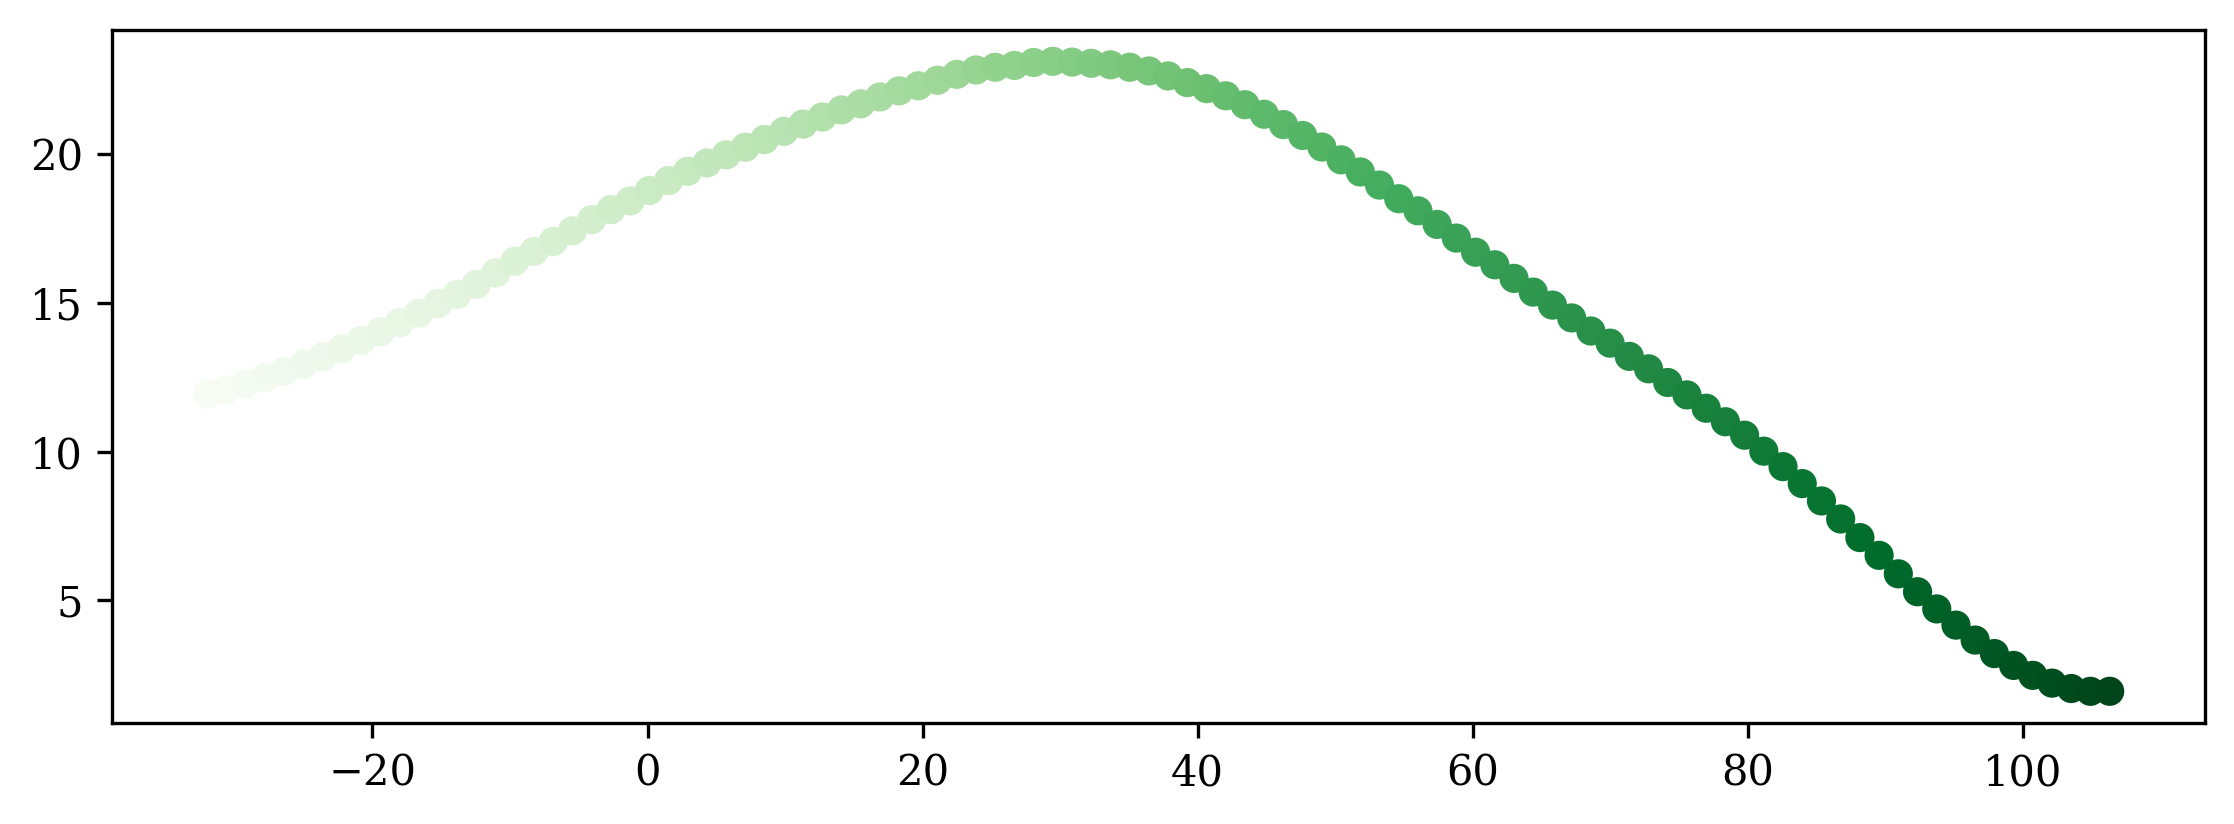

In [69]:
plt.scatter(theta_samples, r2_exact, c=theta_samples, cmap='Greens')

Now set up interpolation to figure out the closest $\theta$ values where we can match to the calculated `r2`.

In [60]:
order = r2_all.argsort()
y_data = r2_all[order]
x_data = theta_all[order]

I think the above interpolation is going wrong. Theta should follow the parabolic curve but because of non-unique $r$ the sorting is not putting the $\theta$ in correct order. Maybe we should try piecewise sorting instead!!

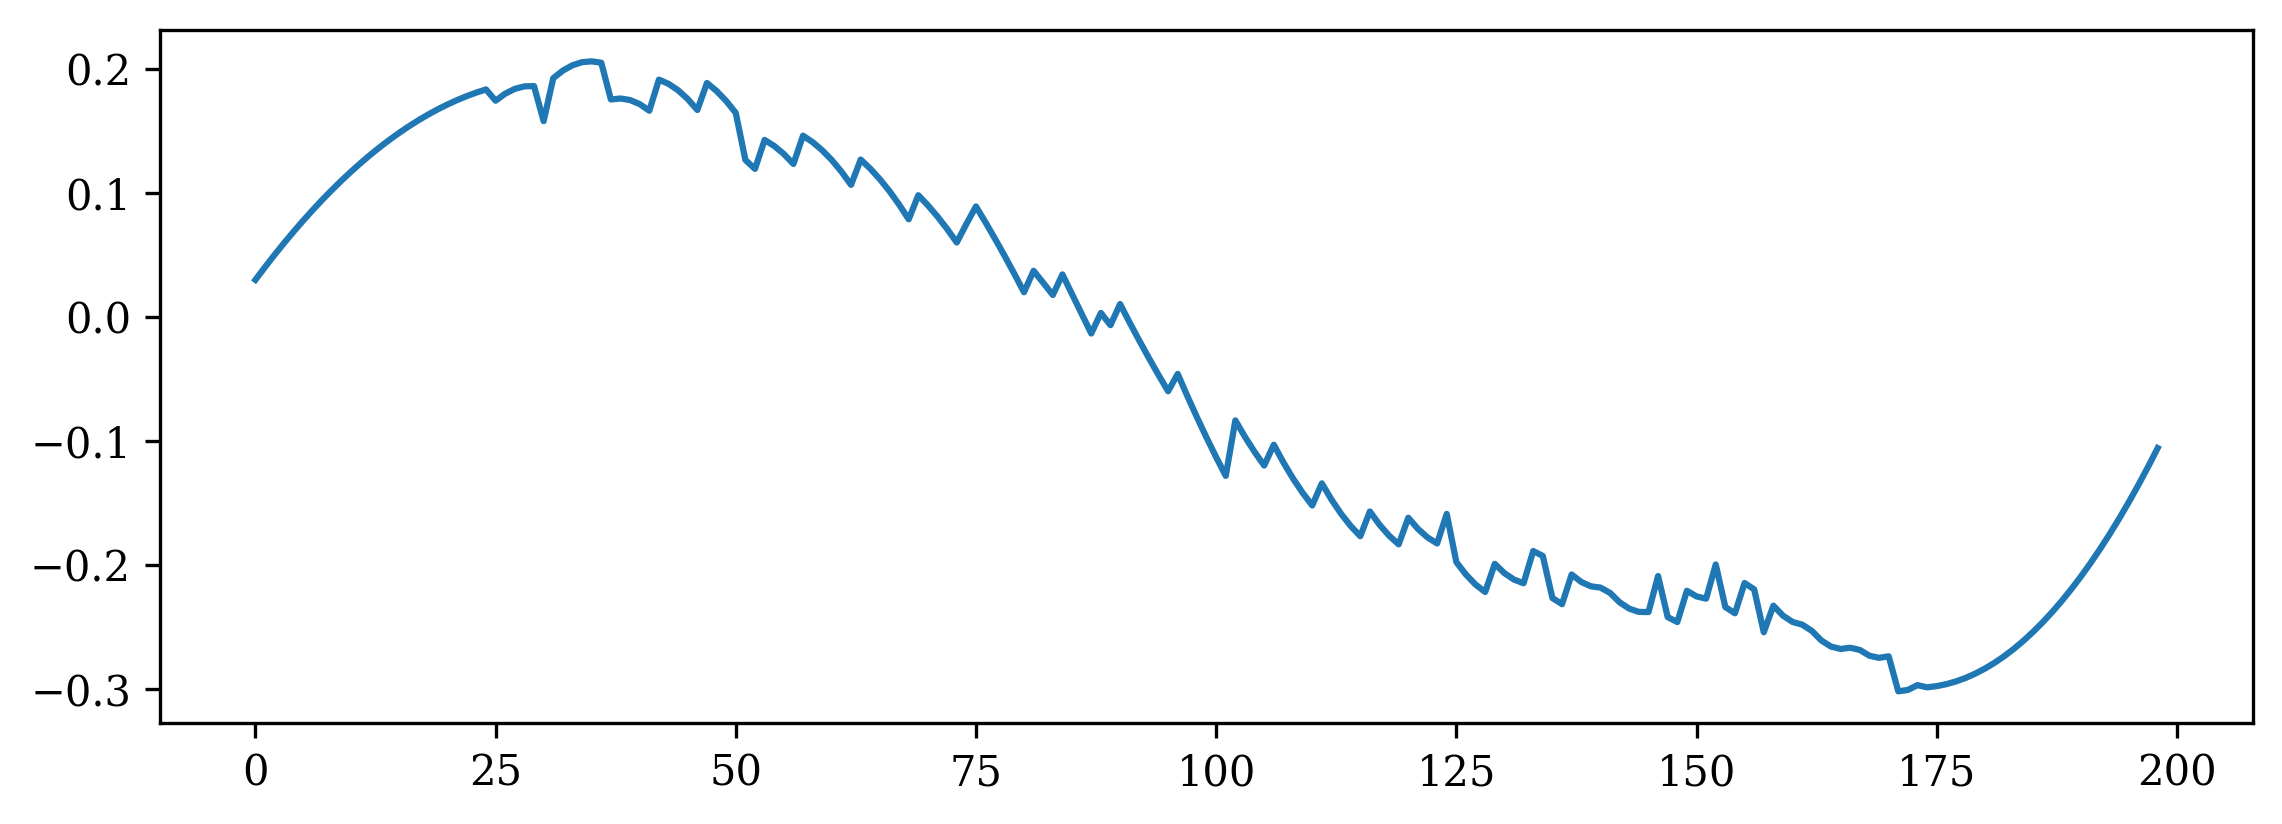

In [70]:
plt.plot(np.diff(r2_all))

We really need to calculate radius instead of pixel values. Its probably not a linear map, that's another reason why we may be going wrong!!!!

In [61]:
theta_interp = np.interp(r2_exact, y_data, x_data)
theta_interp

array([ 80.50162444,  80.03509118,  79.50606976,  78.91131435,
        78.25724872,  62.0531781 , -29.87738689, -27.29240607,
       -25.32190221, -23.59753951, -22.02007745,  36.8909231 ,
        43.22692807,  15.76231515,  68.59152728,  23.52341172,
        26.53165015,  41.56417488, -10.86004901,  56.40931889,
        12.92319246,  18.89889792,  34.14401116,  12.74576813,
        -3.24774159,   5.20544086,  48.35477353,   8.2025355 ,
        42.61065714,  18.66208477,  50.60503753,   4.44976803,
         6.38054641,  25.20402309,   8.05351322,  10.15849117,
        33.56129714,  14.60831029,  32.94188842,  13.5710154 ,
        25.8910875 ,  27.91119535,  32.59889236,  33.34760346,
        27.7773302 ,  37.69312037,  22.54718331,  35.76895676,
        27.11797864,  35.24268428,  36.81685353,  18.80051261,
        22.08123564,  42.97493762,   7.91065994,  27.03444017,
         4.35631711,  39.07002463,  45.95874109,   1.4963466 ,
        14.34930353,  14.15545409,  31.60431606,  39.34

Plot all interpolated $\theta$ and $r$ values.

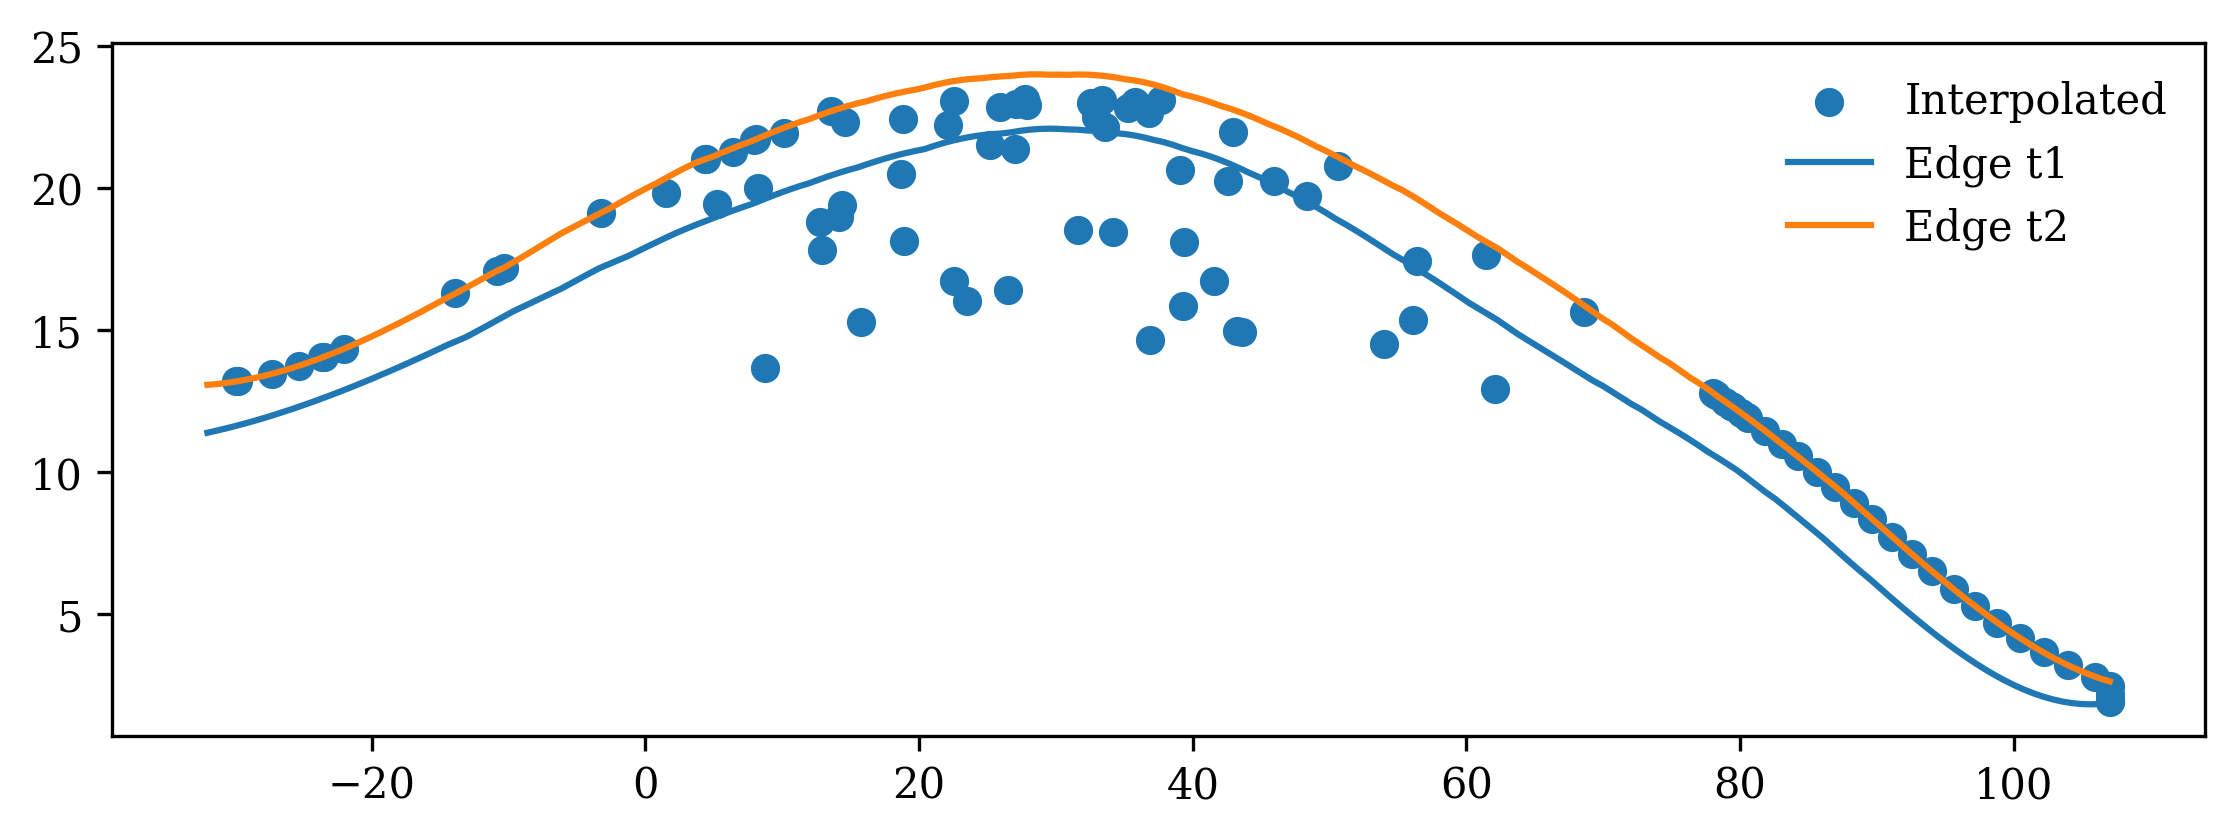

In [39]:
plt.scatter(theta_interp, r2_exact, label="Interpolated")
plt.plot(theta_all, edge1, label="Edge t1")
plt.plot(theta_all, edge2, label="Edge t2")
plt.legend()

Plot $r$ on x-axis and $\theta$ on y-axis. Try `scipy.interpolate` method and see if the result is any different. Do we have to change the scaling to make this work?

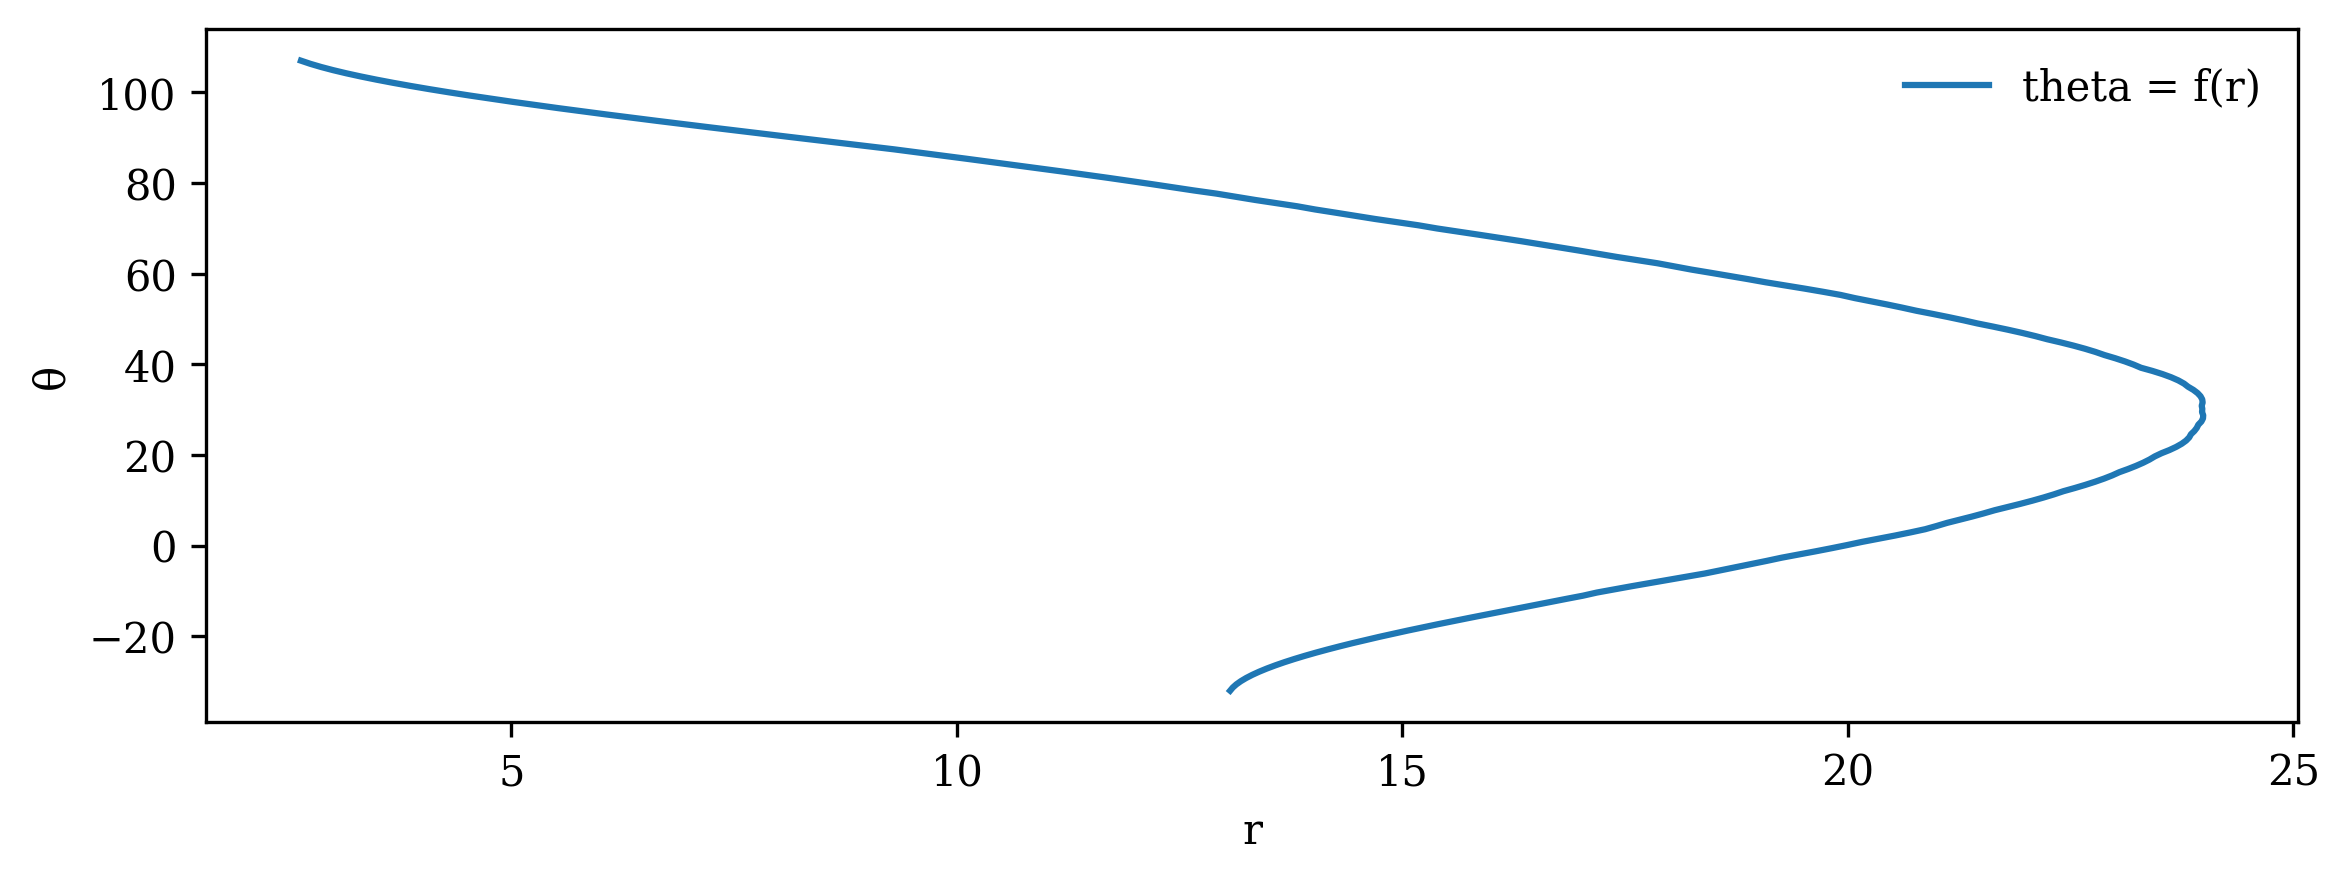

In [45]:
plt.plot(r2_all, theta_all, label="theta = f(r)")
plt.xlabel("r")
plt.ylabel("θ")
plt.legend()

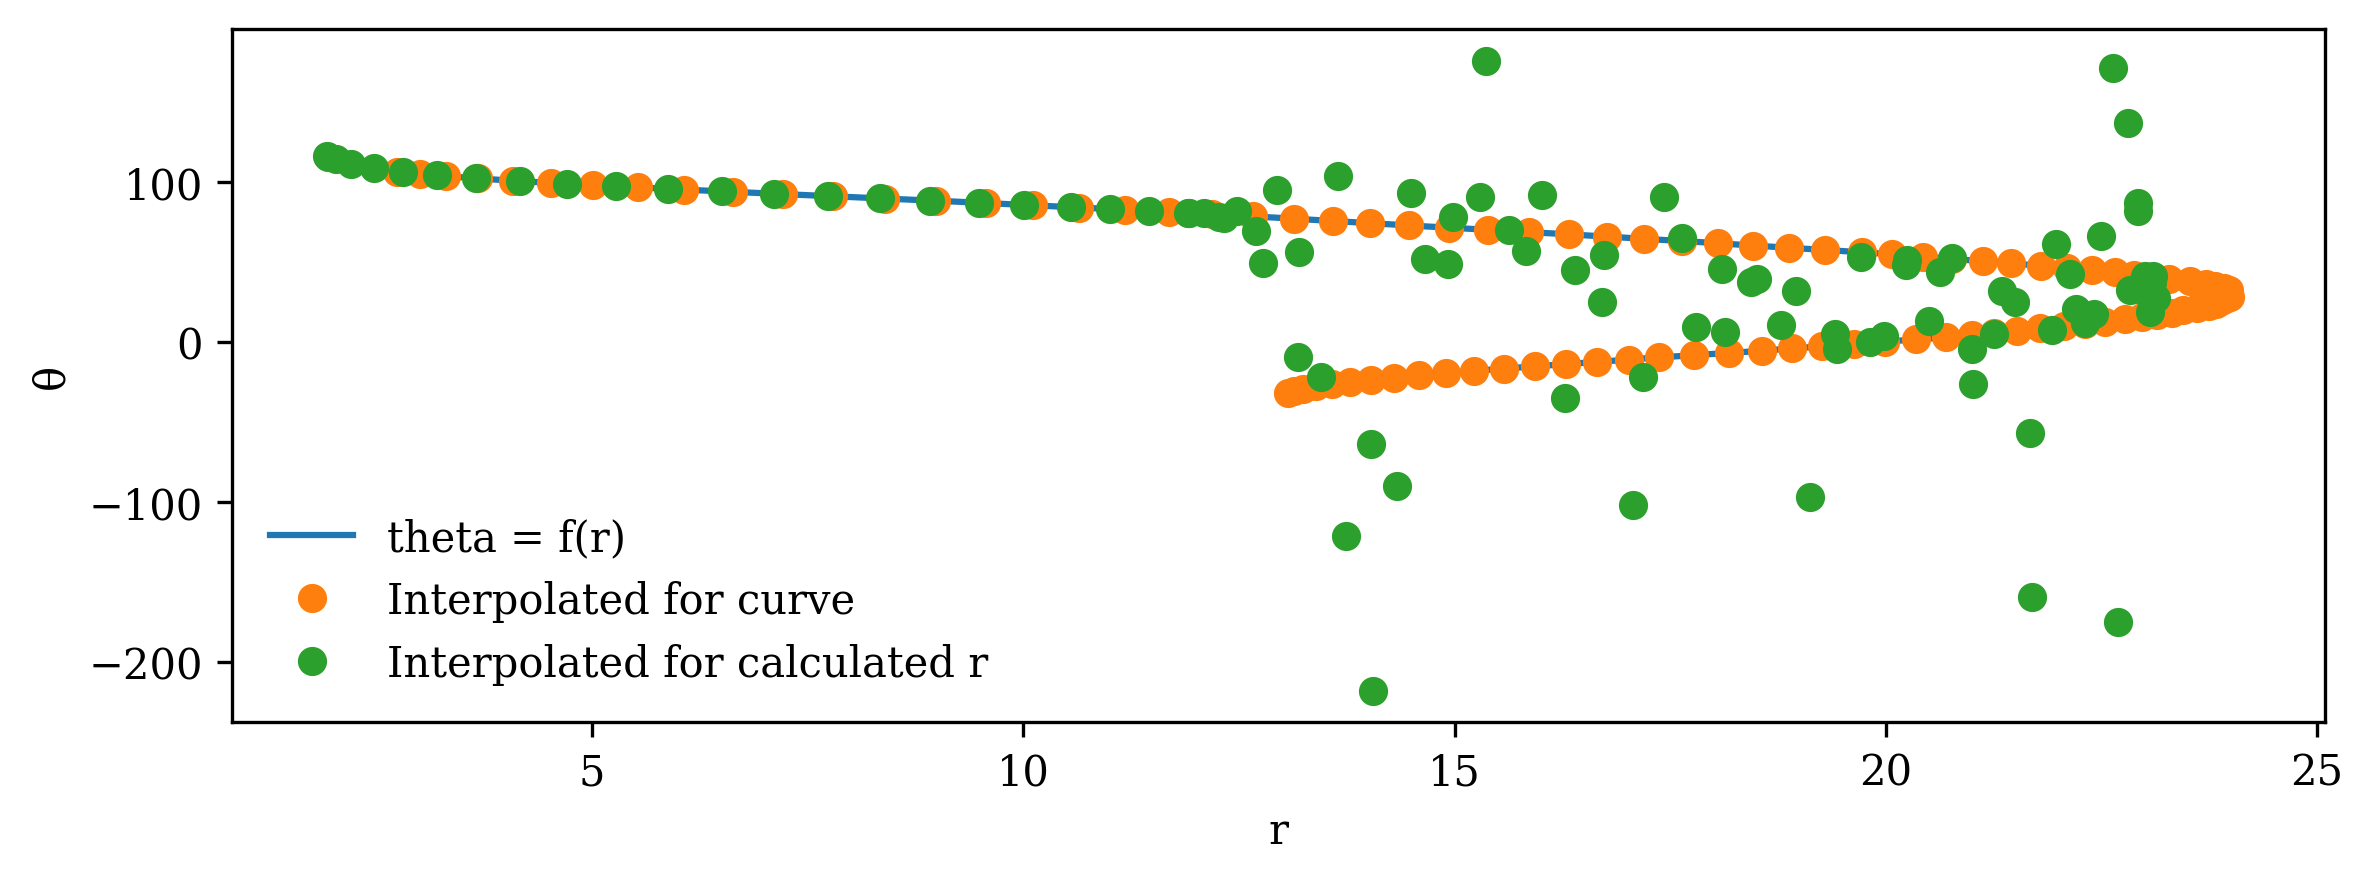

In [49]:
spl = CubicSpline(y_data, x_data)
plt.plot(r2_all, theta_all, label="theta = f(r)")
plt.plot(r2_all[0:-1:2], spl(r2_all[0:-1:2]), 'o', label="Interpolated for curve")
plt.plot(r2_exact, spl(r2_exact), 'o', label="Interpolated for calculated r")


plt.xlabel("r")
plt.ylabel("θ")
plt.legend()

**Approach 1**: Can we change sampling procedure too (non-uniform)? First, we need to deal with the non-monotonicity correctly. Some help thankfully from https://stackoverflow.com/questions/48028766/get-x-values-corresponding-to-y-value-on-non-monotonic-curves

In [53]:
import numpy as np
from scipy.interpolate import interpn


# y_data and x_data are sorted data.

theta_direction = np.sign(np.diff(x_data))

In [62]:
# import numpy as np
# from scipy.interpolate import interp1d

# # convert data lists to arrays
# x, y = np.array(x), np.array(y)

# # sort x and y by x value
# order_vals = np.argsort(x)
# xsort, ysort = x[order_vals], y[order_vals]

# # compute indices of points where y changes direction
# ydirection = np.sign(np.diff(ysort))
# changepoints = 1 + np.where(np.diff(ydirection) != 0)[0]

# # find groups of x and y within which y is monotonic
# xgroups = np.split(xsort, changepoints)
# ygroups = np.split(ysort, changepoints)
# interps = [interp1d(y, x, bounds_error=False) for y, x in zip(ygroups, xgroups)]

# # interpolate all y values
# yval = 100
# xvals = np.array([interp(yval) for interp in interps])

# print(xvals)

**Approach 2**: Nearest neighbours? Find closest matching $(r/t)$ values in edge at next timestep to the previous, and simply use those so that interpolation doesn't have to be optimized (interpolation goes the loong and possibly too complicated? way round trying to find the right $\theta$).

In [71]:
r_by_t_calc = ed31[tMinIdx + 1, 0:-1:2]/(tMin + 2)

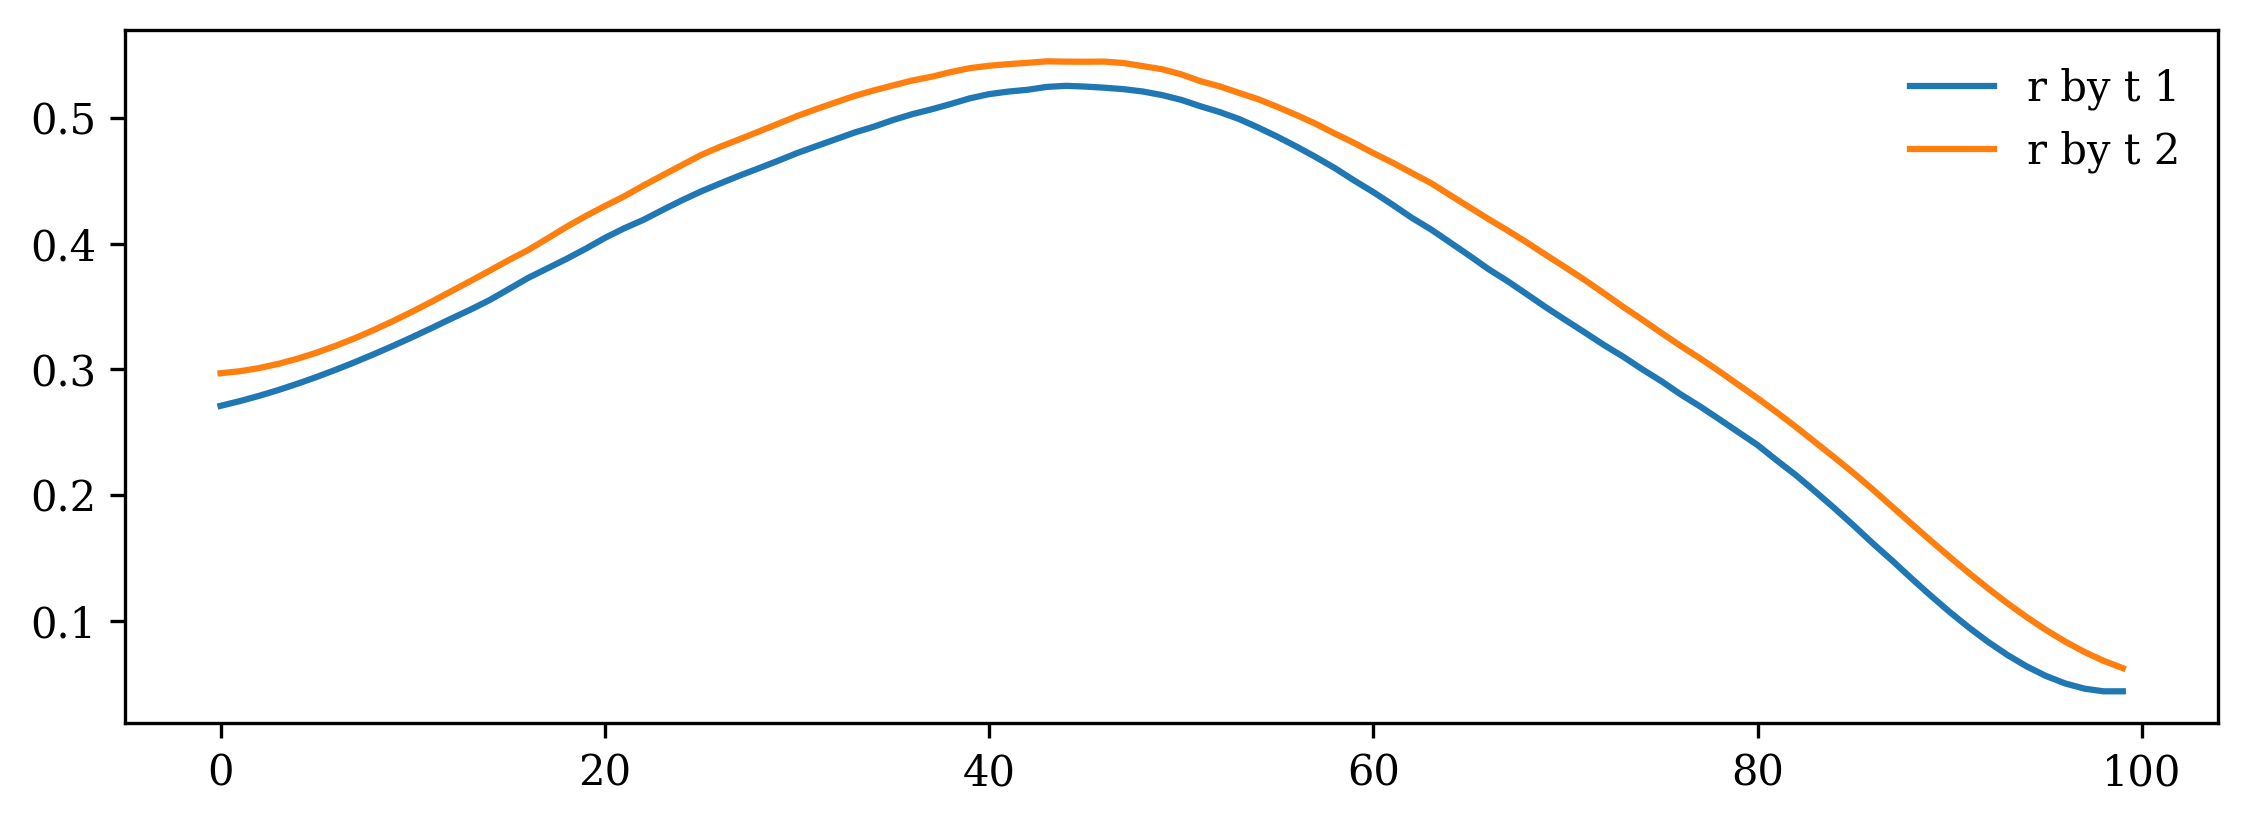

In [72]:
plt.plot(r_by_t_ref, label="r by t 1")
plt.plot(r_by_t_calc, label="r by t 2")
plt.legend()

Also try another scaling.

In [73]:
r_by_sqrt_t_ref = ed31[tMinIdx, 0:-1:2]/np.sqrt(tMin)
r_by_sqrt_t_calc = ed31[tMinIdx + 1, 0:-1:2]/np.sqrt(tMin + 2)

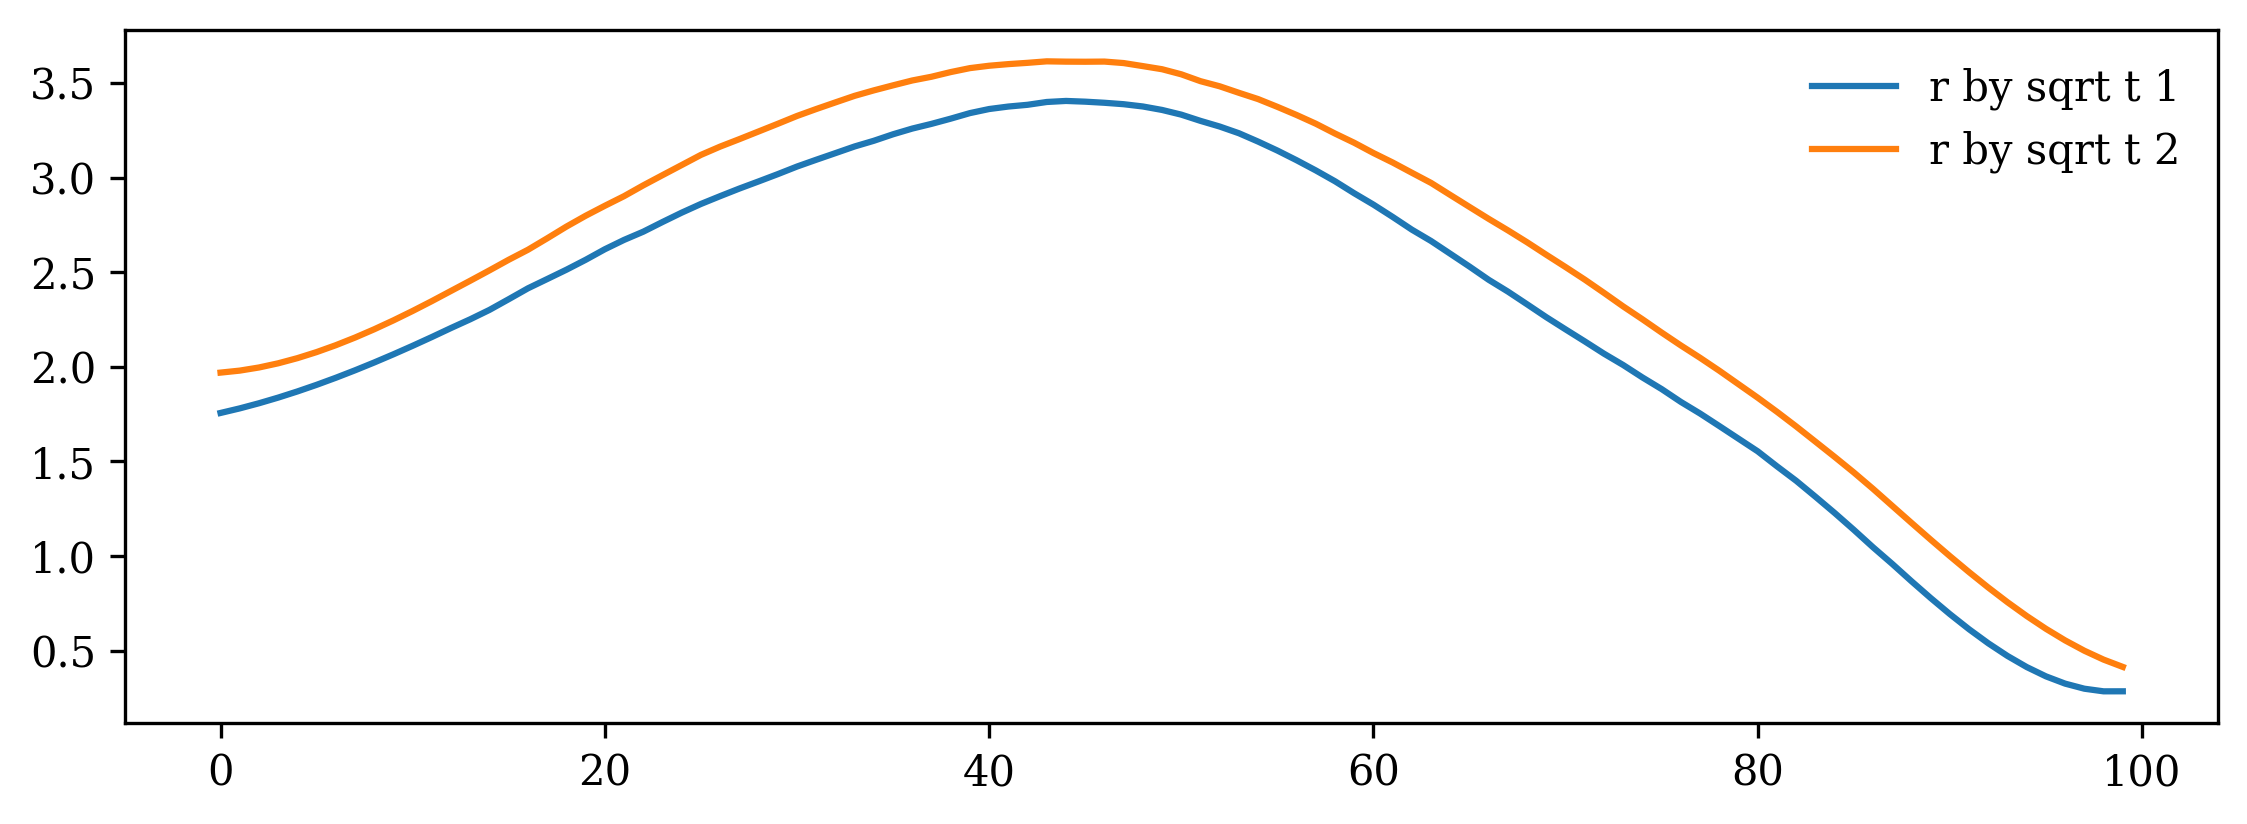

In [74]:
plt.plot(r_by_sqrt_t_ref, label="r by sqrt t 1")
plt.plot(r_by_sqrt_t_calc, label="r by sqrt t 2")
plt.legend()

Check how to convert pixel values into radius correctly. 

1. Paste the edge to cartesian conversion function here. Check if the results match up to Y labels we have been using in multiple edge plots

For angles (from Hongfan):
```
Event: Start, End(x out of 512)
CR2154: 50, 450
CR2161: 160,360
CR2192: 90, 275So the actual angle(suppose (0,1)i s 0 and (1,0) is 90 and so forth) will be 360/512 * x + 1.2 * 180 - 360. Note that, 1.2pi is coming from function Normalization, in which I start at x+1.2pi counterclockwise.Here's an example, for CR2161, the actual angle will be seq(0,360, by = 360/512)[160:359]+1.2*180 - 360 which is equal to [-32, 107]
```

In [81]:
def Polar_to_Cartesian(edge, start_angle, end_angle, height, width, circles_disk, circles_scope):
    theta = np.arange(0, 2 * np.pi, 2 * np.pi / width)[start_angle:end_angle]
    # Coordinates of disk and telescope center
    circle_x = circles_disk[0]
    circle_y = circles_disk[1]
    # Radius of disk and telescope
    r_disk = circles_disk[2]
    r_scope = circles_scope[2]
    Xp = circle_x + r_disk * np.cos(theta + 1.2 * np.pi)
    Yp = circle_y + r_disk * np.sin(theta + 1.2 * np.pi)
    Xi = circle_x + r_scope * np.cos(theta + 1.2 * np.pi)
    Yi = circle_y + r_scope * np.sin(theta + 1.2 * np.pi)
    r = edge / height
    return r + 4.05
# Aniket: Lightly modifying the above to return r instead of X and Y
#     X = Xp + ( Xi - Xp ) * r
#     Y = Yp + ( Yi - Yp ) * r
#     return (X,Y)

In [82]:
height_flattened

128

In [83]:
np.arange(0, height_flattened, step=21)

array([  0,  21,  42,  63,  84, 105, 126])

In [85]:
Polar_to_Cartesian(np.arange(0, height_flattened, step=21),
                   start_angle=160,
                   end_angle=360,
                   height=128,
                   width=512,
                   circles_disk=(149, 149, 19),
                   circles_scope=(149, 149, 110))

array([4.05     , 4.2140625, 4.378125 , 4.5421875, 4.70625  , 4.8703125,
       5.034375 ])

Nope this is not correct.

In [70]:
# # commented out call for saving edge data
# save_event_edge_data(2161, plotAll=False, ax=None, theta_start=160, theta_end=360)
# save_event_edge_data(2192, plotAll=False, ax=None, theta_start=90, theta_end=275)
# save_event_edge_data(2154, plotAll=False, ax=None, theta_start=50, theta_end=450)

In [71]:
# POLAR AXES PLOT
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# # r = np.linspace(4.05, 23.6, height_flattened + 1)
# theta = np.linspace(-32, 107, 90) * np.pi / 180
# ax.plot(theta, ed_2161_scaled[:, :, 0].T[25, :])
# ax.plot(theta, ed_2161_scaled[:, :, 0].T[40, :])
# ax.plot(theta, ed_2161_scaled[:, :, 0].T[50, :])

In [72]:
# plot_edge_data(edge_data_cutoff.T, "Edge data Sim 31", plotAll=False)

**Scratch Begin**

In [32]:
aaa = np.array([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]])

In [37]:
np.min(aaa, axis=1)

array([1, 4, 7])

In [73]:
edge_data_31 = ed_2161[:, :, 0]

In [74]:
tIdx = min(np.unique(np.where(edge_data_31 >= 120)[0]))
tIdx

82

In [75]:
tCutoff = actualTimes[tIdx]
tCutoff

166

In [76]:
edge_data_cutoff = edge_data_31[:tIdx, :]
edge_data_cutoff.shape

(82, 200)

In [77]:
sample_columns = [0, 2, 4, 8, 12, 20, 40, 50, 60, 70]
sample_times = actualTimes[sample_columns]
sample_times

array([  2,   6,  10,  18,  26,  42,  82, 102, 122, 142])

PODBasis
Full-order dimension    n = 200
Reduced-order dimension r = 30


(0.0, 25.0)

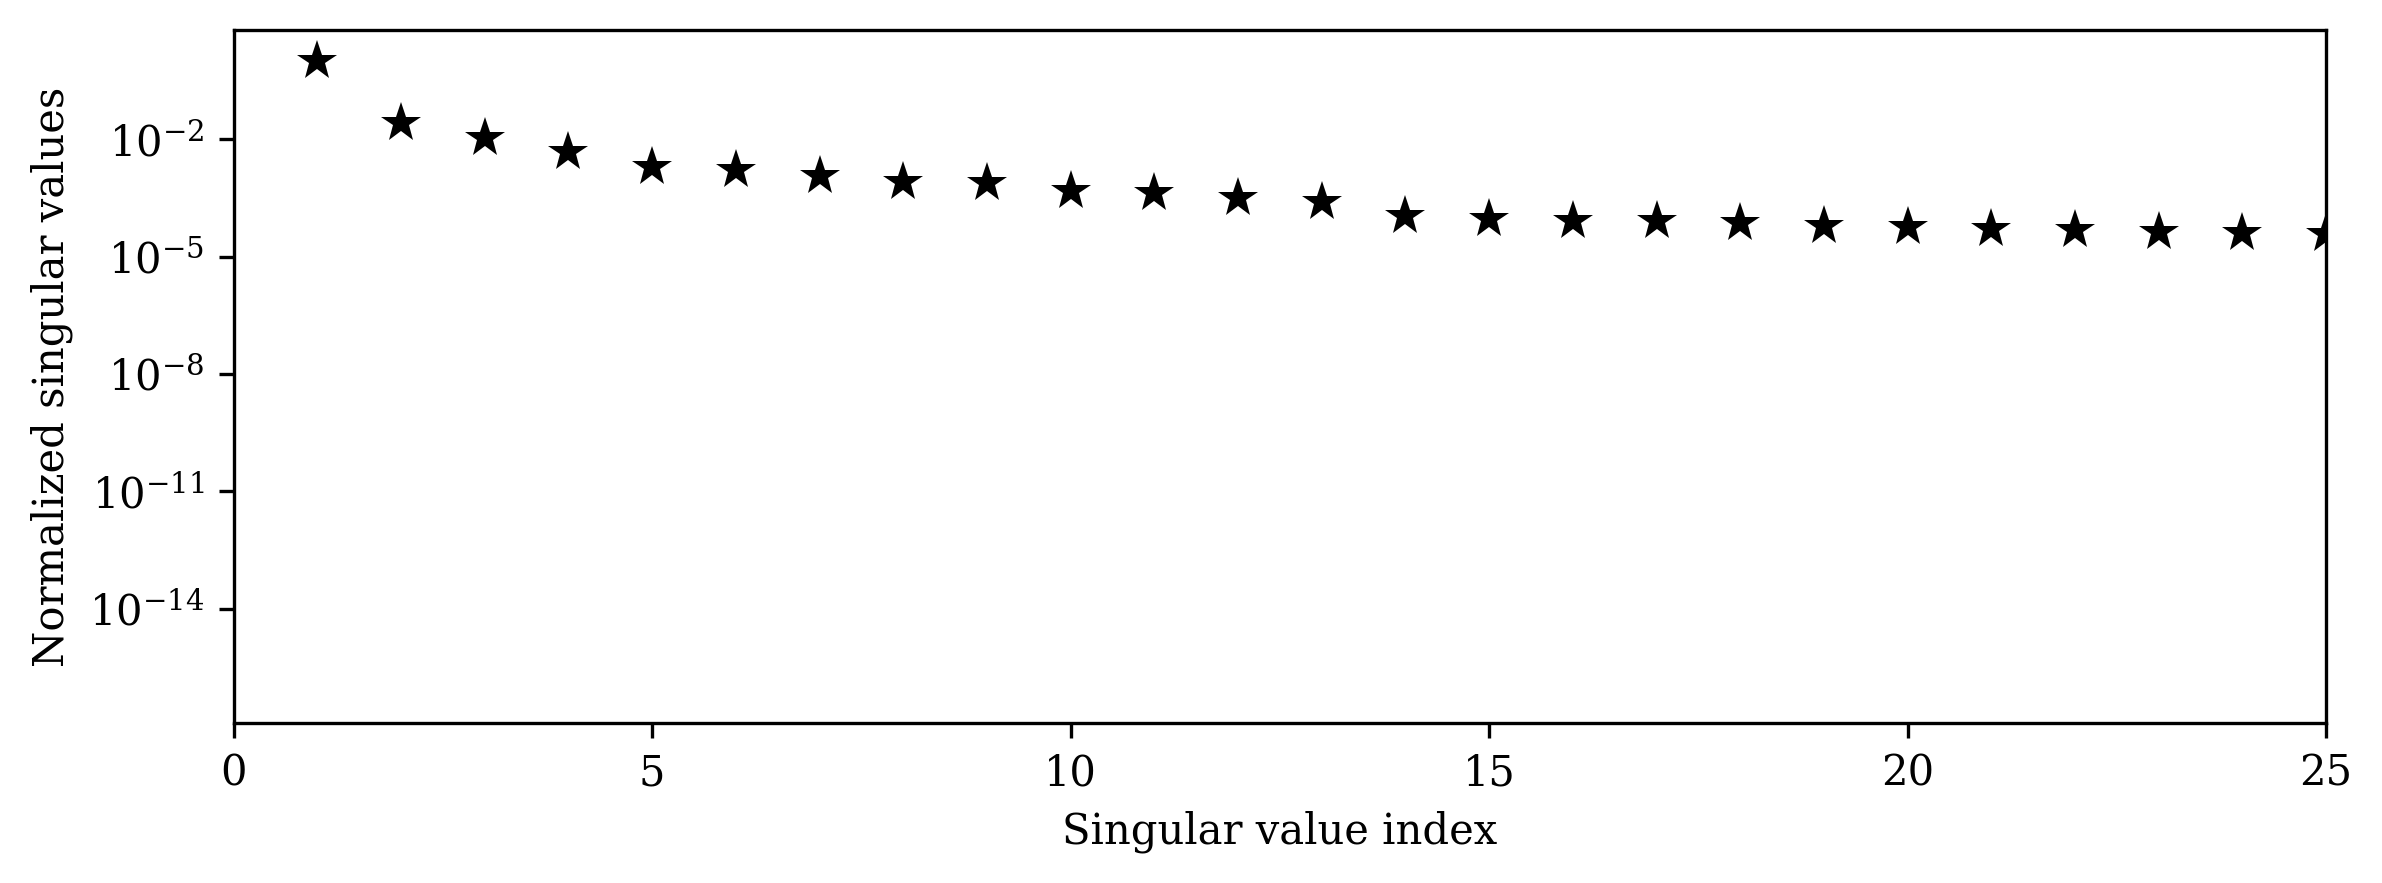

In [78]:
basis = opinf.pre.PODBasis().fit(edge_data_cutoff.T, residual_energy=1e-8)
print(basis)

# Check the decay of the singular values.
basis.plot_svdval_decay()
plt.xlim(0, 25)

(0.0, 10.0)

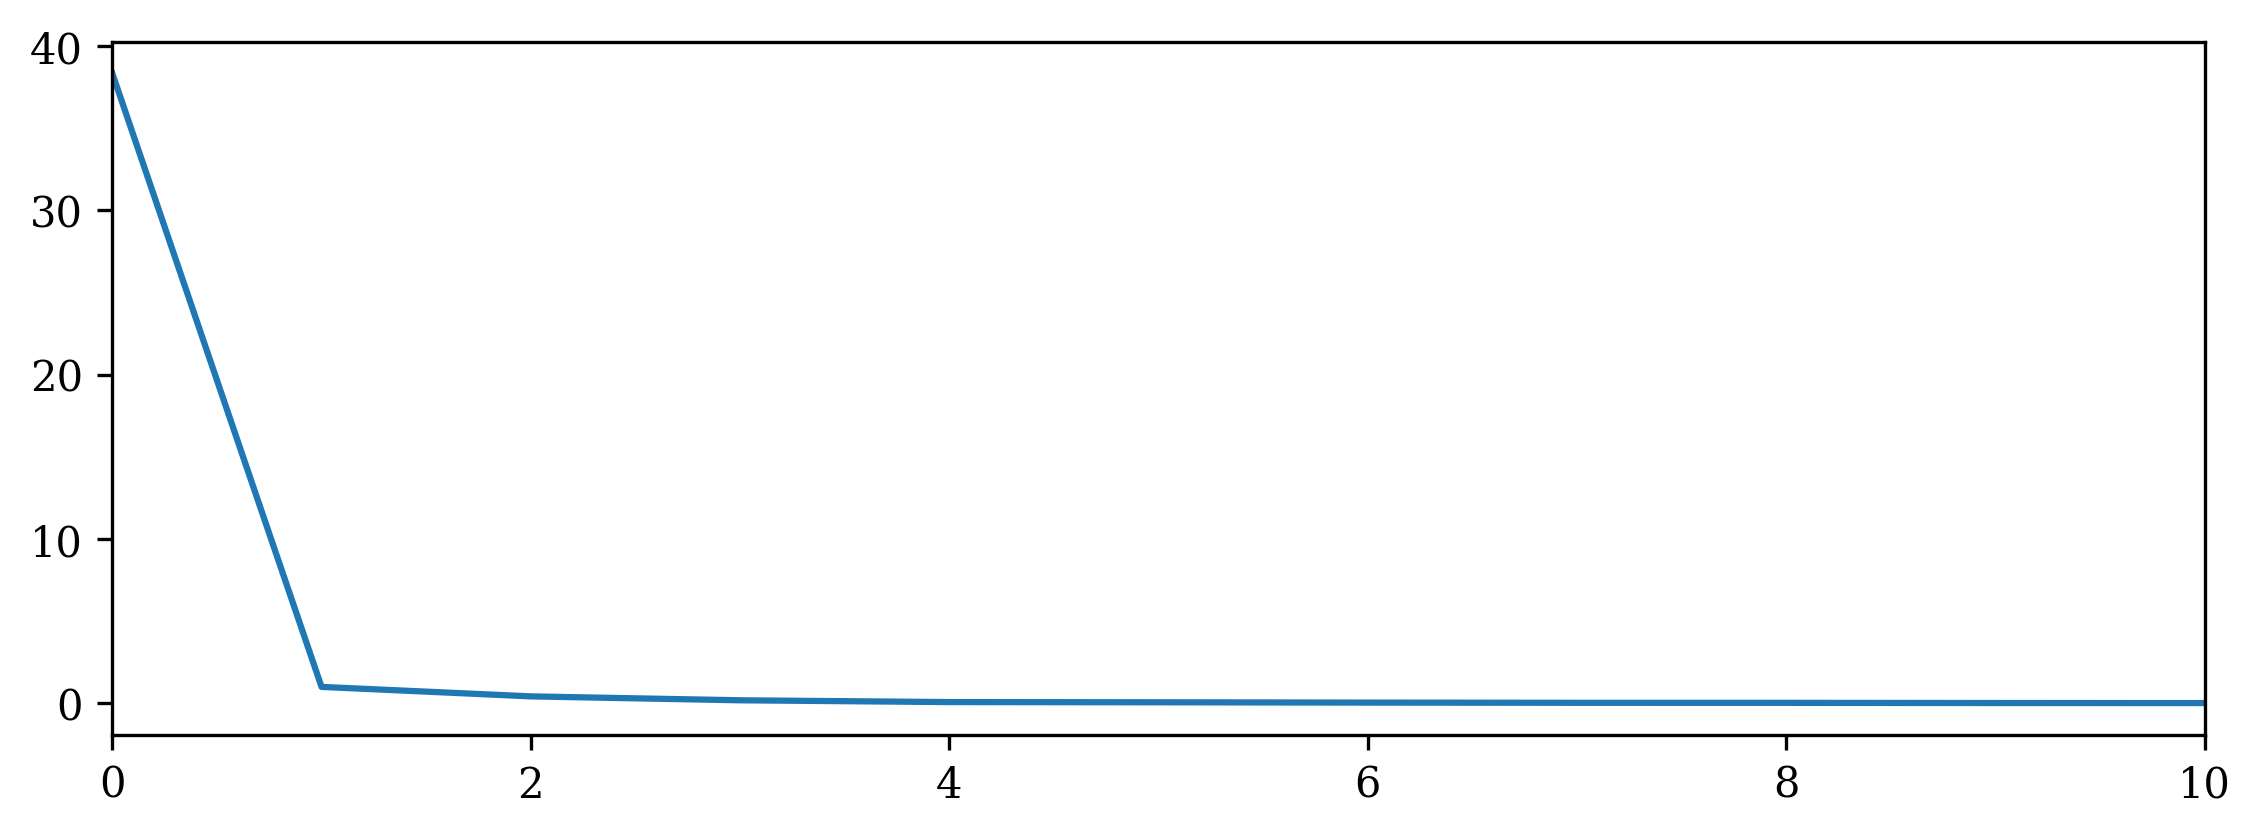

In [79]:
plt.plot(basis.svdvals/basis.svdvals[1])
plt.xlim(0, 10)

**Scratch End**